# Planning IFU Observations
This is a Jupyter notebook for planning IFU observations with Python.  

1. Access Information on a Specific Target using <ins>[Simbad](https://simbad.cds.unistra.fr/simbad/)</ins> and <ins>[NED](http://ned.ipac.caltech.edu/)</ins>.
2. Plot Grayscale Thumbnails (in Color) of the Targets using <ins>[APLpy](https://aplpy.github.io/)</ins>.

## ToDos

2. Visualise the Target through Survey Images using <ins>[Aladin Lite](https://github.com/cds-astro/ipyaladin)</ins> widget. 
3. Search and Download a Photometric catalogue from <ins>[Vizier](https://vizier.cds.unistra.fr/viz-bin/VizieR)</ins>.
4. Overlay Catalog Sources on the Sky View in the Aladin Lite widget along with <ins>[KOOLS-IFU](http://www.o.kwasan.kyoto-u.ac.jp/inst/p-kools/reduction-201806/install_software.html#kools_ifu_red)</ins> Map.
5. Cross-Match the sources with a Large Catalogue using <ins>[X-match](http://cdsxmatch.u-strasbg.fr/)</ins>.

In [1]:
#!/usr/bin/env python
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx----------PLANNING OF IFU OBSERVATIONS---------xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #

# ------------------------------------------------------------------------------------------------------------------- #
# Import Required Libraries
# ------------------------------------------------------------------------------------------------------------------- #
import os
import io
import requests
import numpy as np
import pandas as pd
from PIL import Image

import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats

from urllib.parse import urlencode
from matplotlib import pyplot as plt

# Import Access to Portals and Archives
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch
from astroquery.ipac.ned import Ned

# For Visualization
import aplpy
import ipyaladin.aladin_widget as ipyal
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Global Variables
# ------------------------------------------------------------------------------------------------------------------- #

# ------------------------------------------------------------------------------------------------------------------- #
# Global Variables
# ------------------------------------------------------------------------------------------------------------------- #
ps1filename = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
fitscut = "https://ps1images.stsci.edu/cgi-bin/fitscut.cgi"

list_targets = 'data/Sample_HostBSGSNe - BSGSNe.csv'
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Read Sample of SNe For Fetching Thumbnails
# ------------------------------------------------------------------------------------------------------------------- #

if os.path.exists(list_targets):
    target_df = pd.read_csv(list_targets, comment='#')
    target_df = target_df.drop(['Comment'], axis=1)

# ------------------------------------------------------------------------------------------------------------------- #

Could not import regions, which is required for some of the functionalities of this module.


### Function To Fetch Images from PS1

In [2]:
# ------------------------------------------------------------------------------------------------------------------- #
# Fetch PS1
# ------------------------------------------------------------------------------------------------------------------- #

def fov_to_pixels(fov):
    return int(fov * 240)


def pixels_to_fov(pixels):
    return pixels / 240


def getPS1tab(ra, dec, size=240, filters='grizy', imagetype='stack'):
    """
    Query 'ps1filenames.py' service for finding a list of PanStarrs Reference Images. 
    Args:
        ra        : J2000 Right Ascension (in degrees) 
        dec       : J2000 Declination (in degrees)
        size      : image size in pixels (0.25 arcsec/pixel)
        filters   : string with all the filters to be included
        imagetype : List of any of the acceptable imagetype. Default is stack;
                    other common choices include warp (single-epoch images), stack.wt (weight image),
                    stack.mask, stack.exp (exposure time), stack.num (number of exposures), warp.wt, and warp.mask.
                    This parameter can be a list of strings or a comma-separated string.
    Returns:
        tab       : An astropy table with the list of PS1 Reference Images
    """
    # Convert Imagetypes (if it's a list) to a comma-separated string
    if not isinstance(imagetype, str):
        imagetype = ','.join(imagetype)

    service = ps1filename
    url = ("{service}?ra={ra}&dec={dec}&size={size}&type={imagetype}&format=fits&filters={filters}").format(**locals())
    tab = Table.read(url, format='ascii')

    return tab


def getPS1url(ra, dec, size=240, output_size=None, filters='grizy', fileformat='jpg', imagetype='stack', color=False):
    """
    Obtain URL for PanStarrs Reference Image using 'ps1filenames.py' service.
    Args:
        ra         : J2000 Right Ascension (in degrees) 
        dec        : J2000 Declination (in degrees)
        size       : image size in pixels (0.25 arcsec/pixel)
        filters    : string with all the filters to be included
        fileformat : data format (options are 'fits', 'jpg' or 'png')
        imagetype  : list of any of the acceptable image types.  Default is stack;
                     other common choices include warp (single-epoch images), stack.wt (weight image),
                     stack.mask, stack.exp (exposure time), stack.num (number of exposures), warp.wt, and warp.mask.
                     This parameter can be a list of strings or a comma-separated string.
        color      : Boolean for if a color image is neededif True, creates a color image (only for fileformat='jpg/png').
                     Default is return a list of URLs for single-filter grayscale images.
    Returns:
        url        : Returns a string with the URL
    """
    if color and fileformat == 'fits':
        raise ValueError("ERROR: Color images are only available in 'jpg' or 'png' formats")
    if fileformat not in ('jpg', 'png', 'fits'):
        raise ValueError("ERROR: File format must either be 'jpg', 'png', 'fits'")

    table = getPS1tab(ra, dec, size=size, filters=filters, imagetype=imagetype)
    url = ("{0}?x={ra}&y={dec}&size={size}&wcs=1&format={fileformat}").format(fitscut, **locals())
    
    if output_size:
        url = url + "&size={}".format(output_size)

    flist = ['yzirg'.find(x) for x in table['filter']]
    table = table[np.argsort(flist)]
    
    if color:
        if len(table) > 3:
            # Select 3 filters Automatically for RGB
            table = table[[0, len(table) // 2, len(table) - 1]]
        for idx, colorval in enumerate(['red', 'green', 'blue']):
            url = url + "&{}={}".format(colorval, table['filename'][idx])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase + filename)

    return url


def getPS1color(ra, dec, size=240, output_size=None, filters='grizy', fileformat='jpg'):
    """
    Obtain PS1 Reference Image in Color.
    Args:
        ra          : J2000 Right Ascension (in degrees) 
        dec         : J2000 Declination (in degrees)
        size        : image size in pixels (0.25 arcsec/pixel)
        output_size : output image size in pixels (default = size)
        filters     : string with all the filters to be included
        fileformat  : data format (options are 'jpg' or 'png')
    Returns:
        image       : Returns the Color PS1 images
    """
    if fileformat not in ('jpg', 'png'):
        raise ValueError("ERROR: File format must either be 'jpg' or 'png'")

    url = getPS1url(ra, dec, size=size, filters=filters, output_size=output_size, fileformat=fileformat,
                    color=True)
    
    req = requests.get(url)
    image = Image.open(io.BytesIO(req.content))
    
    return image


def getPS1gray(ra, dec, size=240, output_size=None, filter='g', fileformat="jpg"):
    """
    Obtain PS1 Reference Image in Grayscale.
    Args:
        ra          : J2000 Right Ascension (in degrees) 
        dec         : J2000 Declination (in degrees)
        size        : image size in pixels (0.25 arcsec/pixel)
        output_size : output image size in pixels (default = size)
        filters     : string with all the filters to be included
        fileformat  : data format (options are 'jpg' or 'png')
    Returns:
        image       : Returns the Color PS1 images
    """
    if fileformat not in ('jpg', 'png'):
        raise ValueError("ERROR: File format must either be 'jpg' or 'png'")
    if filter not in list('grizy'):
        raise ValueError("ERROR: Filter must be chosen from 'grizy'")
        
    url = getPS1url(ra, dec, size=size, filters=filter, output_size=output_size, fileformat=fileformat)
    
    req = requests.get(url[0])
    image = Image.open(io.BytesIO(req.content))
    
    return image
# ------------------------------------------------------------------------------------------------------------------- #


### Functions for Plotting Image Thumbnails

In [3]:
# ------------------------------------------------------------------------------------------------------------------- #
# Functions for Plotting Thumbnails
# ------------------------------------------------------------------------------------------------------------------- #

def extract_contrast(hdulist, low=3, high=10):
    """
    Extract contrast values for plotting data from 'hdulist'. The contrast values 'low' and 'high' are 
    extracted in terms of standard deviation of the Image data.
    Args:
        hdulist : HDUList from which image data has to be extracted
        low     : Min. Contrast value to be exracted in terms of 'sigma'
        high    : Max. Contrast value to be exracted in terms of 'sigma'
    Returns:
        vmin    : Min. Contrast Value
        vmax    : Max. Contrast Value

    """
    data = hdulist[0].data
    stats = sigma_clipped_stats(data)
    vmin = stats[1] - low * stats[2]
    vmax = stats[1] + high * stats[2]
    
    return vmin, vmax


def set_aplpyparams(fig, title):
    """
    Set plot parameters using APLPy.
    Args:
        fig     : Figure object onto which plot parameters are to be set
        title   : Set title for the figure
    """
    # Add Grid
    fig.add_grid()
    fig.grid.set_alpha(0.8)
    
    # Add Colorbar
    fig.add_colorbar()
    fig.colorbar.show()
    fig.colorbar.set_location('right')
    fig.colorbar.set_width(0.3)
    fig.colorbar.set_axis_label_text('Counts')
    fig.colorbar.set_axis_label_font(size=12)
    fig.colorbar.set_font(size='medium', weight='medium', stretch='normal', family='sans-serif',
                          style='normal', variant='normal')

    # Add Scalebar
    fig.add_scalebar(5 * u.arcsecond)
    # fig.scalebar.set_length(5 * u.arcsecond)
    # fig.scalebar.set_label('5 arcsec')
    fig.scalebar.set_color('black')

    fig.scalebar.set_corner('top right')
    fig.scalebar.set_linestyle('solid')
    fig.scalebar.set_linewidth(2)
    fig.scalebar.set_frame(True)  

    # Ticks
    fig.ticks.set_color('black')
    fig.ticks.set_length(10)
    fig.ticks.set_minor_frequency(5)

    # Tick Labels
    fig.tick_labels.set_xformat('hh:mm:ss.s')
    fig.tick_labels.set_yformat('dd:mm:ss.s')
    fig.tick_labels.set_font(size='large', weight='medium', stretch='normal', family='sans-serif',
                             style='normal', variant='normal')

    # Axis Labels
    fig.axis_labels.set_xtext('Right Ascension (J2000)')
    fig.axis_labels.set_ytext('Declination (J2000)')
    fig.axis_labels.set_font(size='x-large', weight='medium', stretch='normal', family='sans-serif', \
                             style='normal', variant='normal')
    
    # Set Title
    fig.set_title(title)
    
    
def plot_grayscale(name, hdulist, title, low=3, high=10):
    """
    Plot GrayScale images and set plot parameters using APLPy.
    Args:
        name    : SN for which the finding chart has to be plotted
        hdulist : HDUList from which image data has to be extracted
        title   : Set title for the figure
        low     : Min. Contrast value to be set in terms of 'sigma'
        high    : Max. Contrast value to be set in terms of 'sigma'
    """
    fig = aplpy.FITSFigure(hdulist)
    vmin, vmax = extract_contrast(hdulist, low, high)
    
    # fig.show_grayscale(stretch='arcsinh', vmin=vmin, vmax=vmax)
    # fig.show_colorscale(cmap='coolwarm', stretch='arcsinh')
    fig.show_colorscale(cmap='coolwarm', stretch='arcsinh', vmin=vmin, vmax=vmax)
    set_aplpyparams(fig, title)

    fig.save("FindingCharts/PLOTGray_{0}.jpg".format(name))
    fig.set_auto_refresh(True)

    # fig.show_markers(object_coords.ra, object_coords.dec, edgecolor='red', marker='s', s=100**2)
    # fig.set_theme('publication')


def plot_colorscale(name, hdulists, low=3, high=10):
    """
    Plot ColorScale images and set plot parameters using APLPy.
    Args:
        name    : SN for which the finding chart has to be plotted
        hdulist : HDUList from which image data has to be extracted
        low     : Min. Contrast value to be set in terms of 'sigma'
        high    : Max. Contrast value to be set in terms of 'sigma'
    """
    cwd = os.getcwd()
    plotwd = os.path.join(cwd, 'FindingCharts')

    if not os.path.exists(plotwd):
        os.mkdir(plotwd)
    os.chdir(plotwd)
    
    # Make an RGB Data Cube
    aplpy.make_rgb_cube(hdulists, '{0}_RGBCube.fits'.format(name))

    # Make RGB image - Linear
    aplpy.make_rgb_image('{0}_RGBCube.fits'.format(name), '{0}_RGBCube_Linear.jpg'.format(name))

    # Make RGB image - ArcSinh
    aplpy.make_rgb_image('{0}_RGBCube.fits'.format(name), '{0}_RGBCube_ArcSinh.jpg'.format(name),
                         stretch_r='arcsinh', stretch_g='arcsinh', stretch_b='arcsinh')

    fig = aplpy.FITSFigure('{0}_RGBCube.fits'.format(name))    
    fig.show_rgb('{0}_RGBCube_ArcSinh.jpg'.format(name))
    
    vmin, vmax = extract_contrast('{0}_RGBCube.fits'.format(name), low, high)
    fig.show_colorscale(cmap='coolwarm', stretch='arcsinh', vmin=vmin, vmax=vmax)
    # fig.show_colorscale(cmap='gist_heat')
    set_aplpyparams(fig)
    
    fig.save("PLOTColor_{0}.jpg".format(name))
    fig.set_auto_refresh(True)

    os.chdir(cwd)

# ------------------------------------------------------------------------------------------------------------------- #


In [4]:
target_df

,ID,Name,RA,DEC,Redshift,HostGalaxy,ZTFName,Magnitude,Run,Remarks,RASN,DECSN
0,1,2004em,19:31:31,35:52:25,0.014930,IC 1303,INDEF,(r=13.4),1,NaN,19:31:31.31,35:52:16.16
1,2,2019pkh,02:19:27,34:04:54,0.020000,Anonymous,ZTF19abuzinv,NaN,2,Very Faint HOST,02:19:27.27,34:04:55.55
2,3,2004ek,01:09:59,32:22:36,0.017420,UGC 724,NaN,(R=12.75),1,NaN,01:09:59.59,32:22:48.48
3,4,2021cwe,15:45:32,30:09:30,0.031681,LEDA 214414,ZTF21aakvroo,(r=16.53),1,NaN,15:45:31.31,30:09:43.43
4,5,2021wun,15:46:32,25:25:45,0.022805,SDSS J154631.94+252545.5,ZTF21abtephz,(r=17.29),1,NaN,15:46:32.32,25:25:45.45
5,6,2020xkx,23:20:28,22:59:13,0.041500,Anonymous,ZTF20acklcyp,NaN,2,Small Host Visible (Not Catalogued),23:20:28.28,22:59:13.13
6,7,2021ydc,01:25:18.18,22:23:25.25,0.055000,WISEA J012517.64+222324.8,ZTF21abxlmuw,(W1=17.9),2,NaN,01:25:18.18,22:23:25.25
7,8,2018ego,15:52:53,19:58:09,0.037000,LEDA 1611826,ZTF18ablhrpz,(r=16.55),1,NaN,15:52:54.54,19:58:05.05
8,9,2020rmk,03:52:55,19:19:25,0.025000,LEDA 1588264,ZTF20abqlmwn,(J=15.04),1,NaN,03:52:56.56,19:19:33.33
9,10,2018imj,06:51:06,12:55:07,0.013000,IC 454,ZTF18abytyif,(J=12.99),1,NaN,06:51:06.06,12:54:56.56


### Plot GrayScale Thumbnail (In Color)

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
/home/avinash/Softwares/miniconda3/lib/python3.10/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linestyle. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/home/avinash/Softwares/miniconda3/lib/python3.10/site-packages/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astr

IndexError: list index out of range

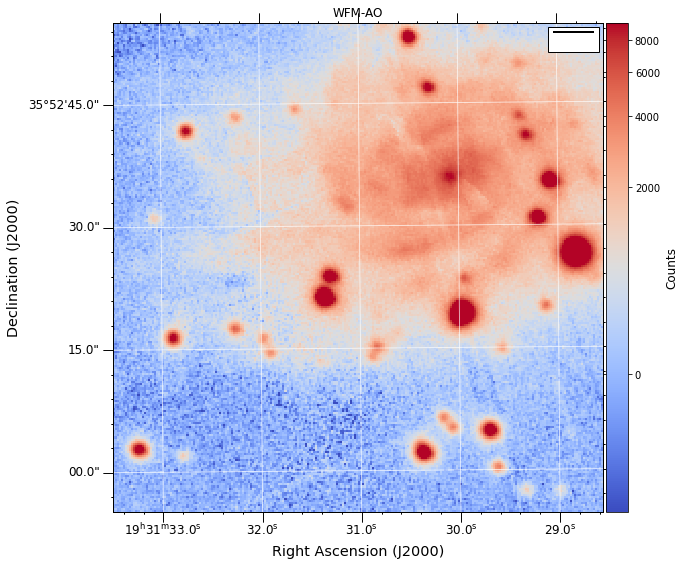

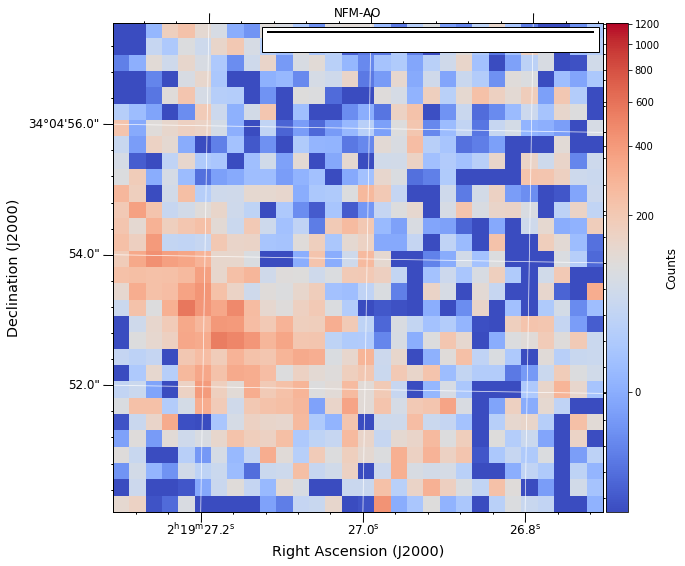

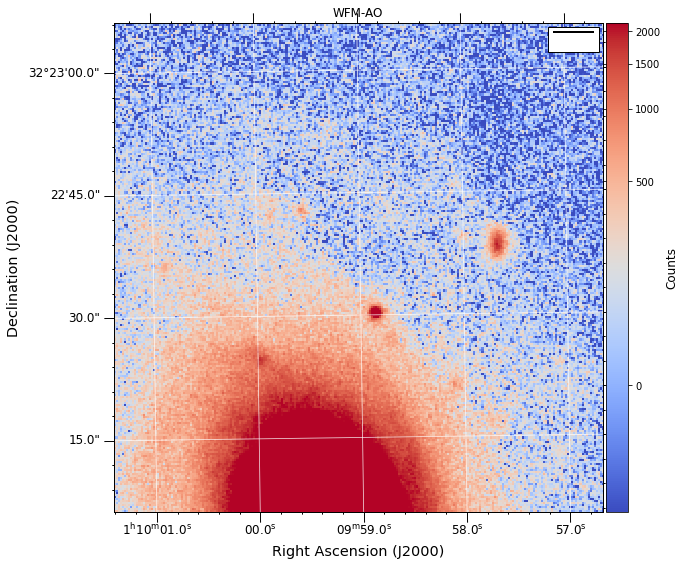

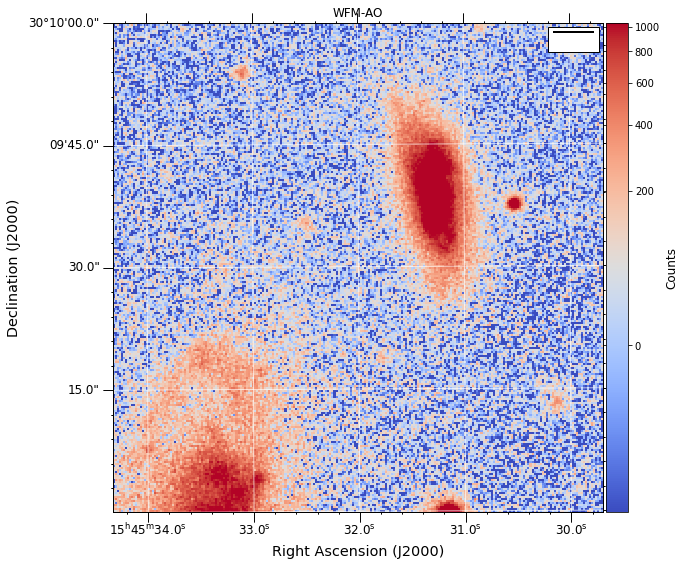

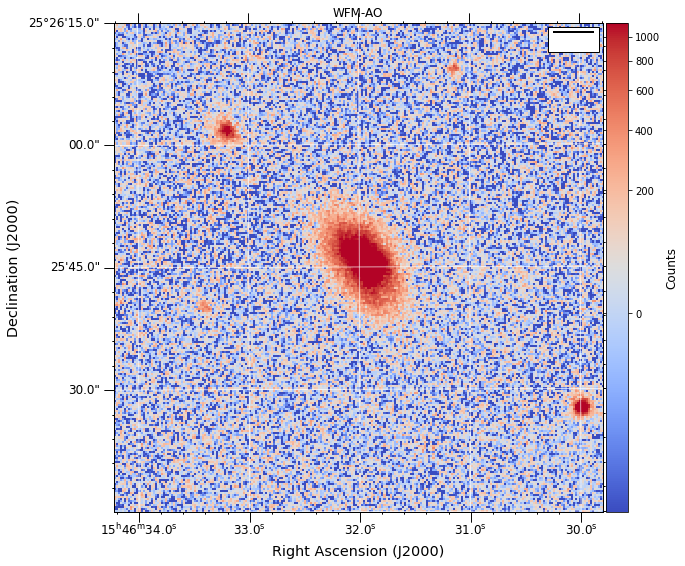

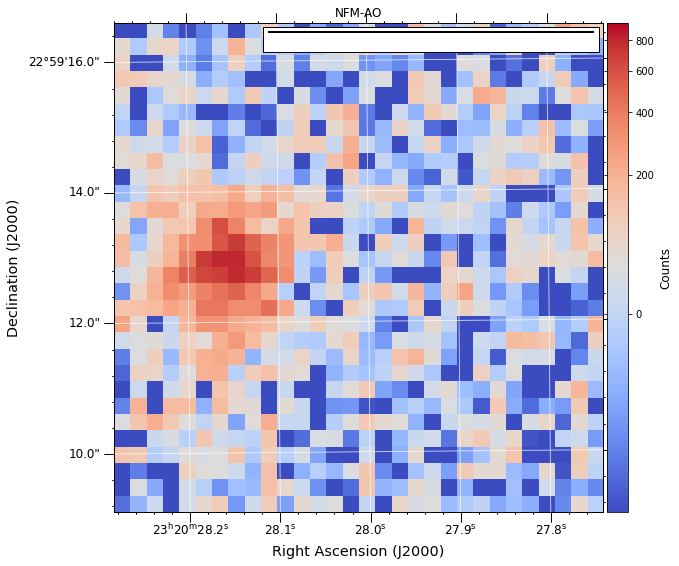

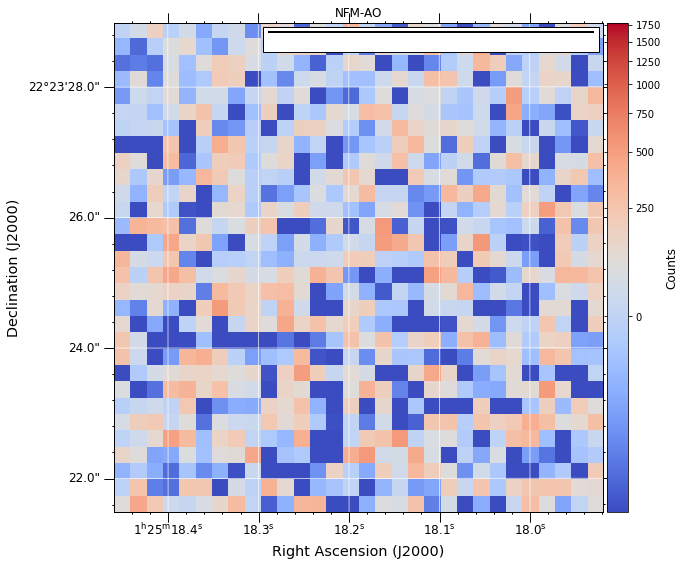

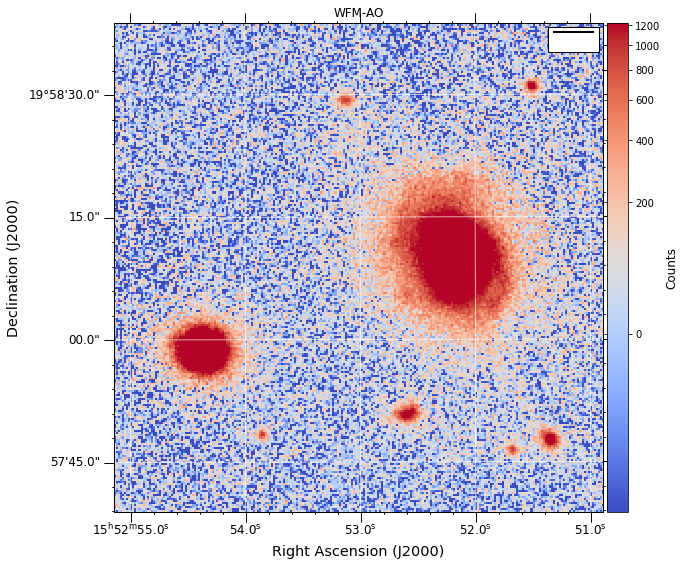

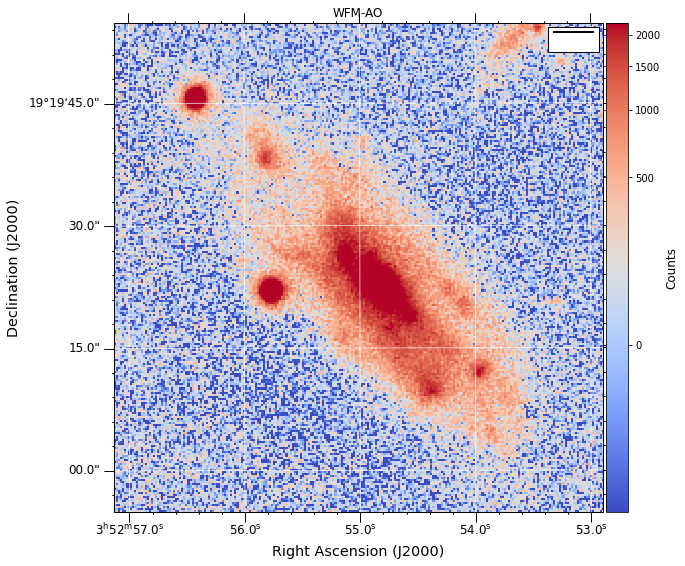

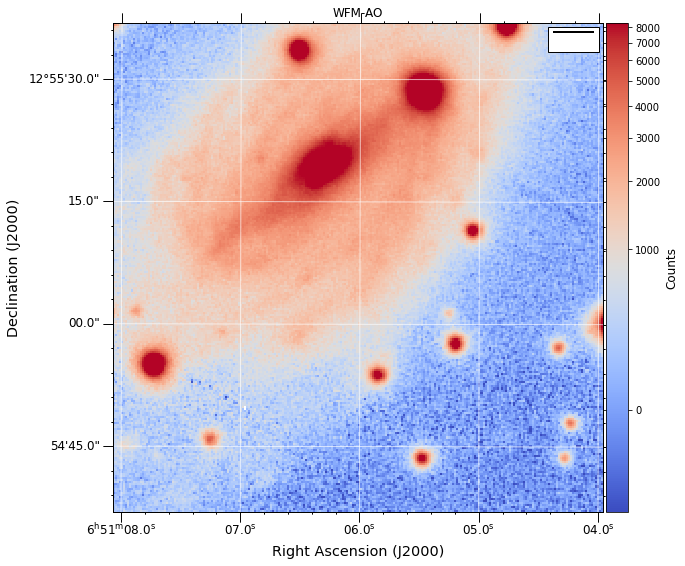

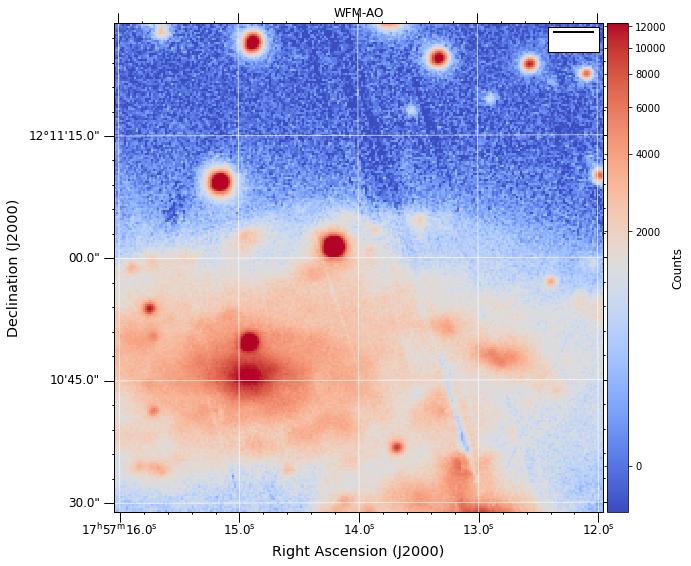

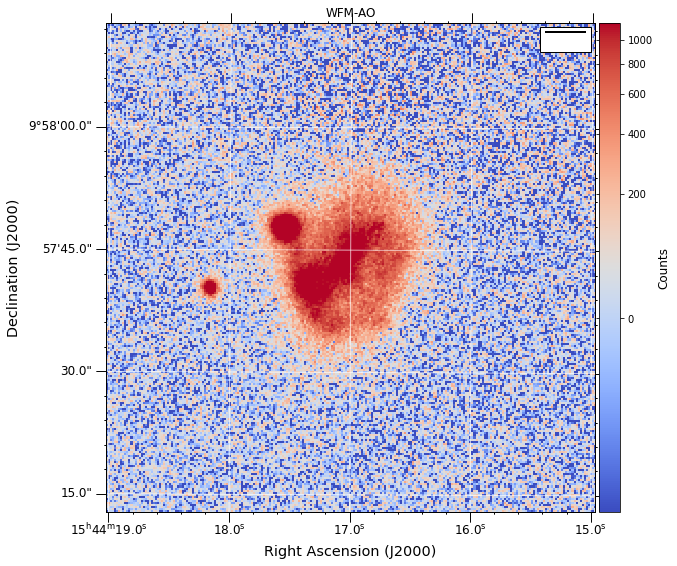

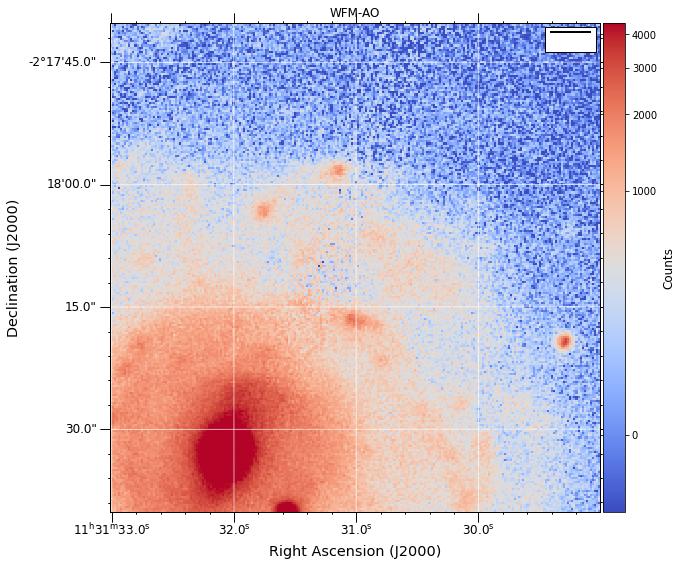

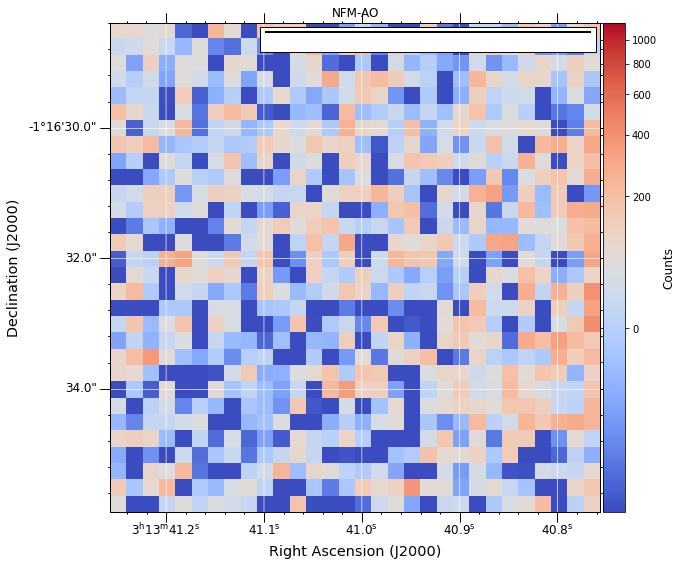

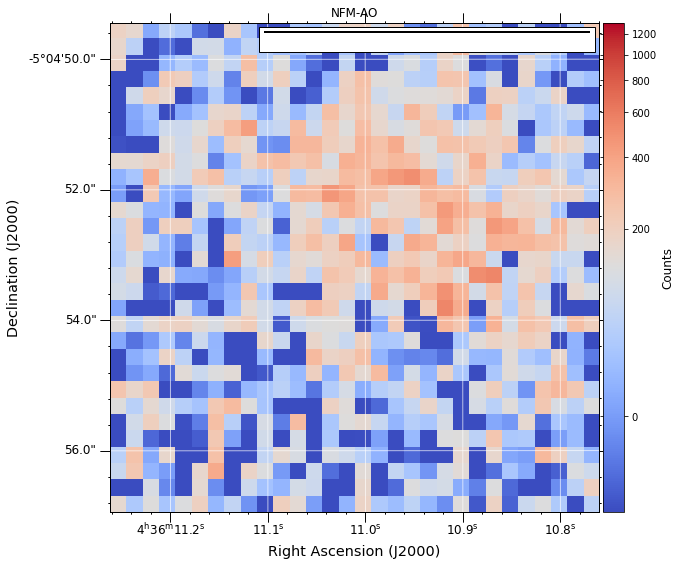

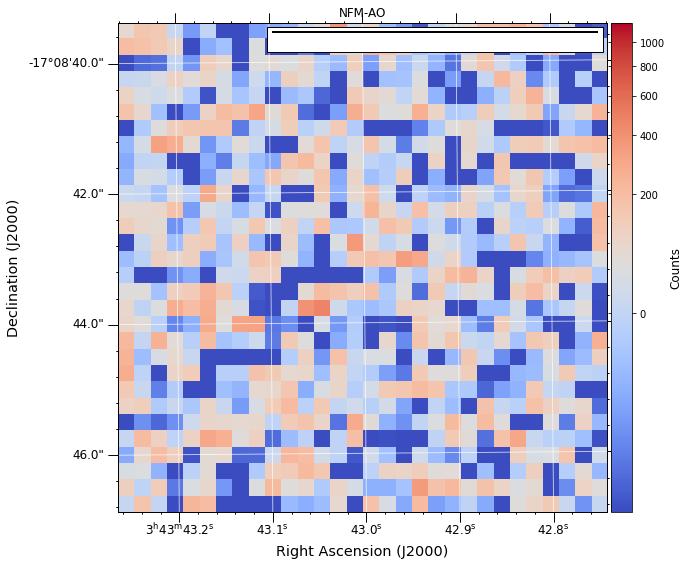

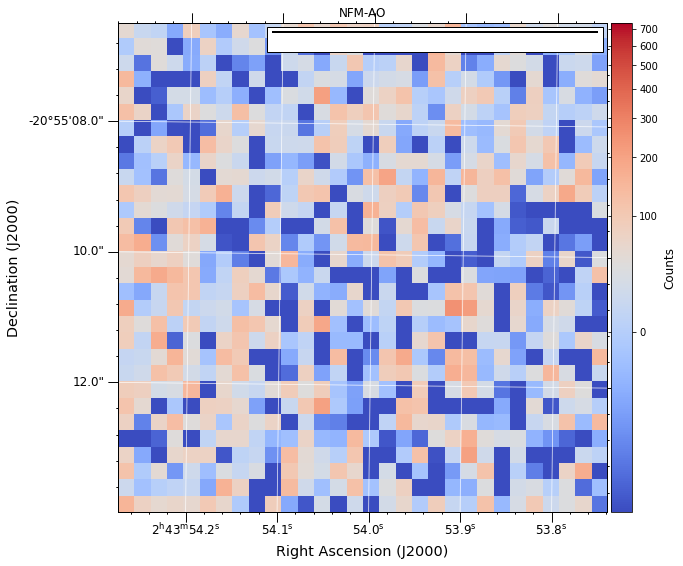

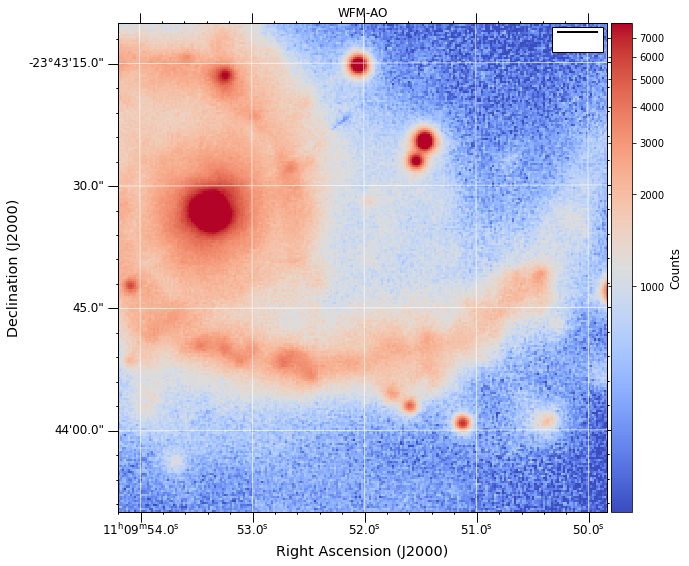

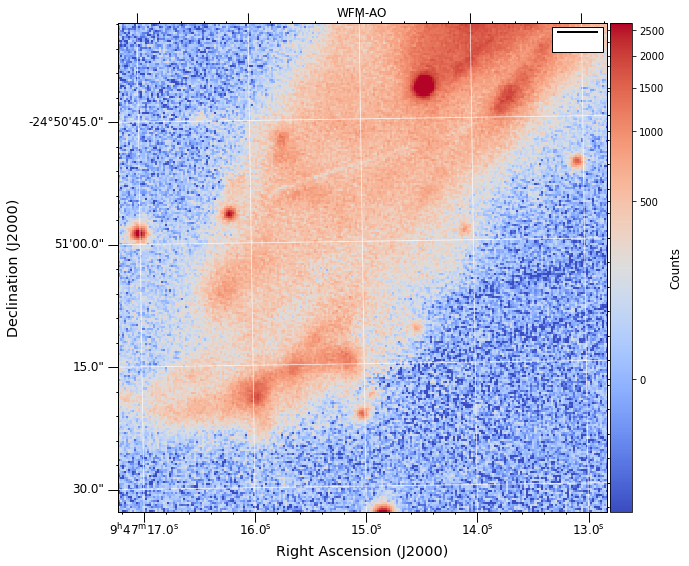

In [5]:
# ------------------------------------------------------------------------------------------------------------------- #

if not os.path.exists(os.path.join(os.getcwd(), 'findingcharts')):
    os.mkdir('findingcharts')

for _, sn_df in target_df.iterrows():
    name, ra, dec, run = sn_df[['Name', 'RA', 'DEC', 'Run']]
    object_coords = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))

    query_sim = Simbad.query_region(object_coords)
    query_ned = Ned.query_region(object_coords)
    # print (query_sim)
    # print (query_ned)
    # print (Ned.get_table(query_ned[0]['Object Name'], table='photometry'))

    # Plot GrayScale Image
    if int(run) == 2:
        ps1gray = getPS1url(object_coords.ra.value, object_coords.dec.value, size=fov_to_pixels(0.125), filters='r', fileformat='fits')
        hdugray = fits.open(ps1gray[0])
        plot_grayscale(name, hdugray, title='NFM-AO', low=1, high=10)

    else:
        ps1gray = getPS1url(object_coords.ra.value, object_coords.dec.value, size=fov_to_pixels(1), filters='r', fileformat='fits')
        hdugray = fits.open(ps1gray[0])
        plot_grayscale(name, hdugray, title='WFM-AO', low=1, high=10)

# ------------------------------------------------------------------------------------------------------------------- #

### Plot Color Thumbnail (In Development)

In [ ]:
# ------------------------------------------------------------------------------------------------------------------- #

for _, sn_df in target_df.iterrows():
    name, ra, dec = sn_df[['Name', 'RA', 'DEC']]
    object_coords = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))

    query_sim = Simbad.query_region(object_coords)
    query_ned = Ned.query_region(object_coords)

    ps1color = getPS1url(object_coords.ra.value, object_coords.dec.value, size=fov_to_pixels(2), filters='gri', fileformat='fits')
    ps1r = getPS1url(object_coords.ra.value, object_coords.dec.value, size=fov_to_pixels(2), filters='i', fileformat='fits')
    ps1g = getPS1url(object_coords.ra.value, object_coords.dec.value, size=fov_to_pixels(2), filters='r', fileformat='fits')
    ps1b = getPS1url(object_coords.ra.value, object_coords.dec.value, size=fov_to_pixels(2), filters='g', fileformat='fits')

    # Plot Color Image
    hdur = fits.open(ps1r[0])
    hdug = fits.open(ps1g[0])
    hdub = fits.open(ps1b[0])
    print (ps1r, ps1g, ps1b)
    plot_colorscale(name, [ps1r[0], ps1g[0], ps1b[0]], 2, 30)
# ------------------------------------------------------------------------------------------------------------------- #